In [1]:
import warnings
warnings.filterwarnings("ignore")

# Отключим логирование в Prophet

import logging

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True


In [2]:
!pip install etna[auto]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━

In [2]:
# Параметры кросс-валидации

from etna.metrics import SMAPE

HORIZON = 31
N_FOLDS = 3

def eval_pipeline(pipeline):
    metrics_df, forecast_df, fold_info_df = pipeline.backtest(
        ts=ts, n_folds=N_FOLDS, metrics=[SMAPE()], aggregate_metrics=True
    )
    return metrics_df.mean()


# Загрузка данных

В этом задании мы попробуем улучшить качество модели прогнозирования засчет удаления аномалий из обучающего датасета

Для начала загрузим чистые данные и построим на них базовый пайплайн

In [3]:
import pandas as pd
from etna.datasets.tsdataset import TSDataset
from etna.pipeline import Pipeline
from etna.models import ProphetModel

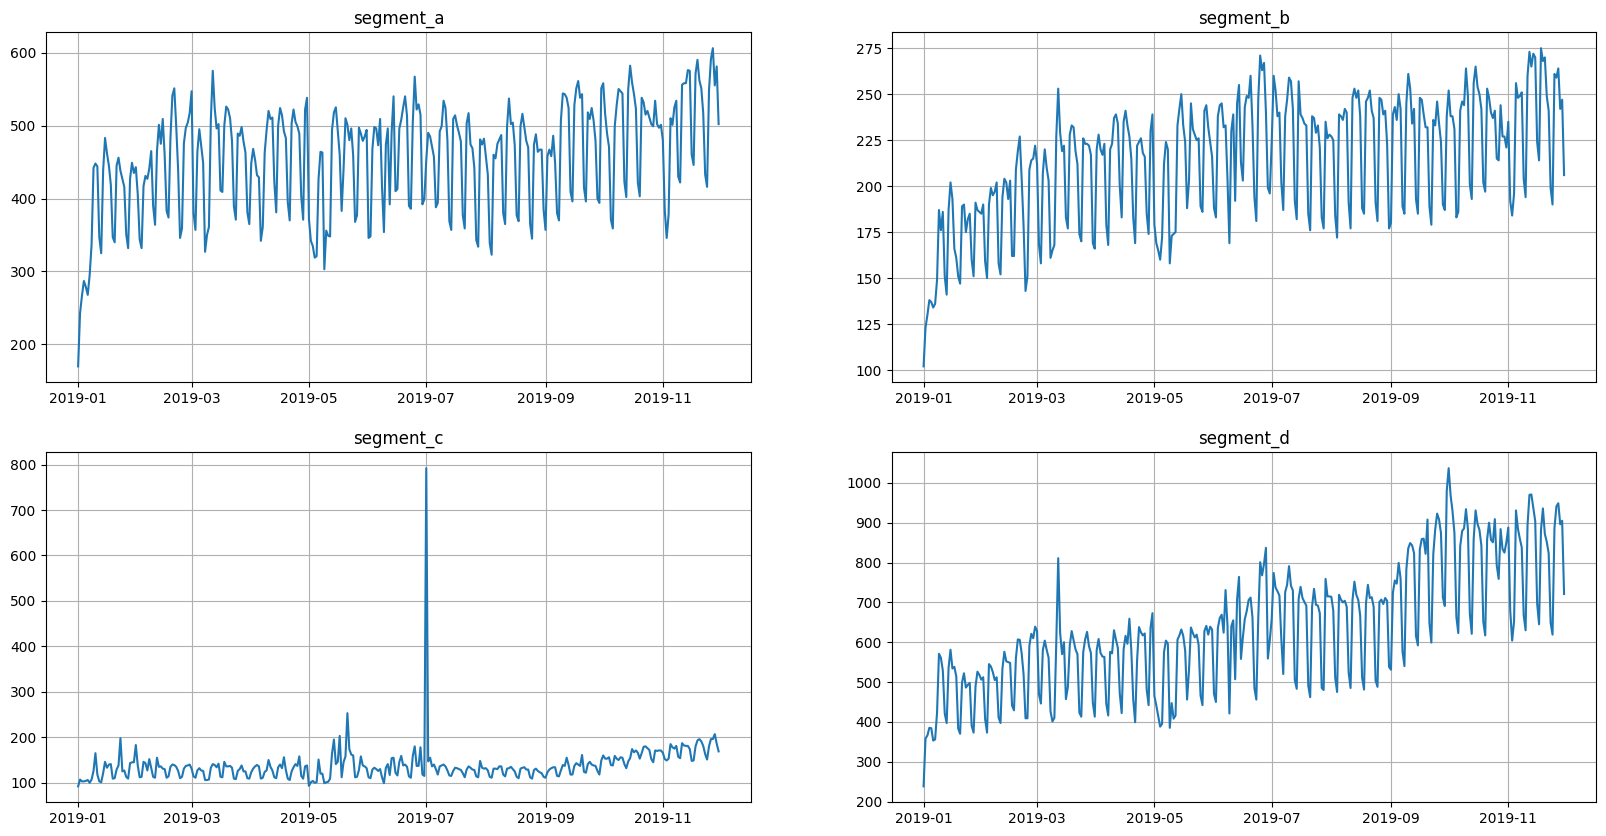

In [4]:
df = pd.read_csv("example_dataset.csv")
ts = TSDataset(df=df, freq="D")
ts.plot()

Можем считать, что это базовая метрика, к которой мы дальше будем стремиться

In [5]:
base_pipeline = Pipeline(
    model=ProphetModel(),
    transforms=[],
    horizon=HORIZON
)
base_metric = eval_pipeline(base_pipeline)
base_metric

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.3s
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily 

,0
SMAPE,8.435081


# Загрузка данных с аномалиями

Каким-то неизвестным образом в обучающей части датасета появились аномалии(их в целом видно на картинке). Давайте оценим насколько испортилась модель в их присутствии

**Важно:** на тестовой части датасета(где оценивается метрика) аномалий нет

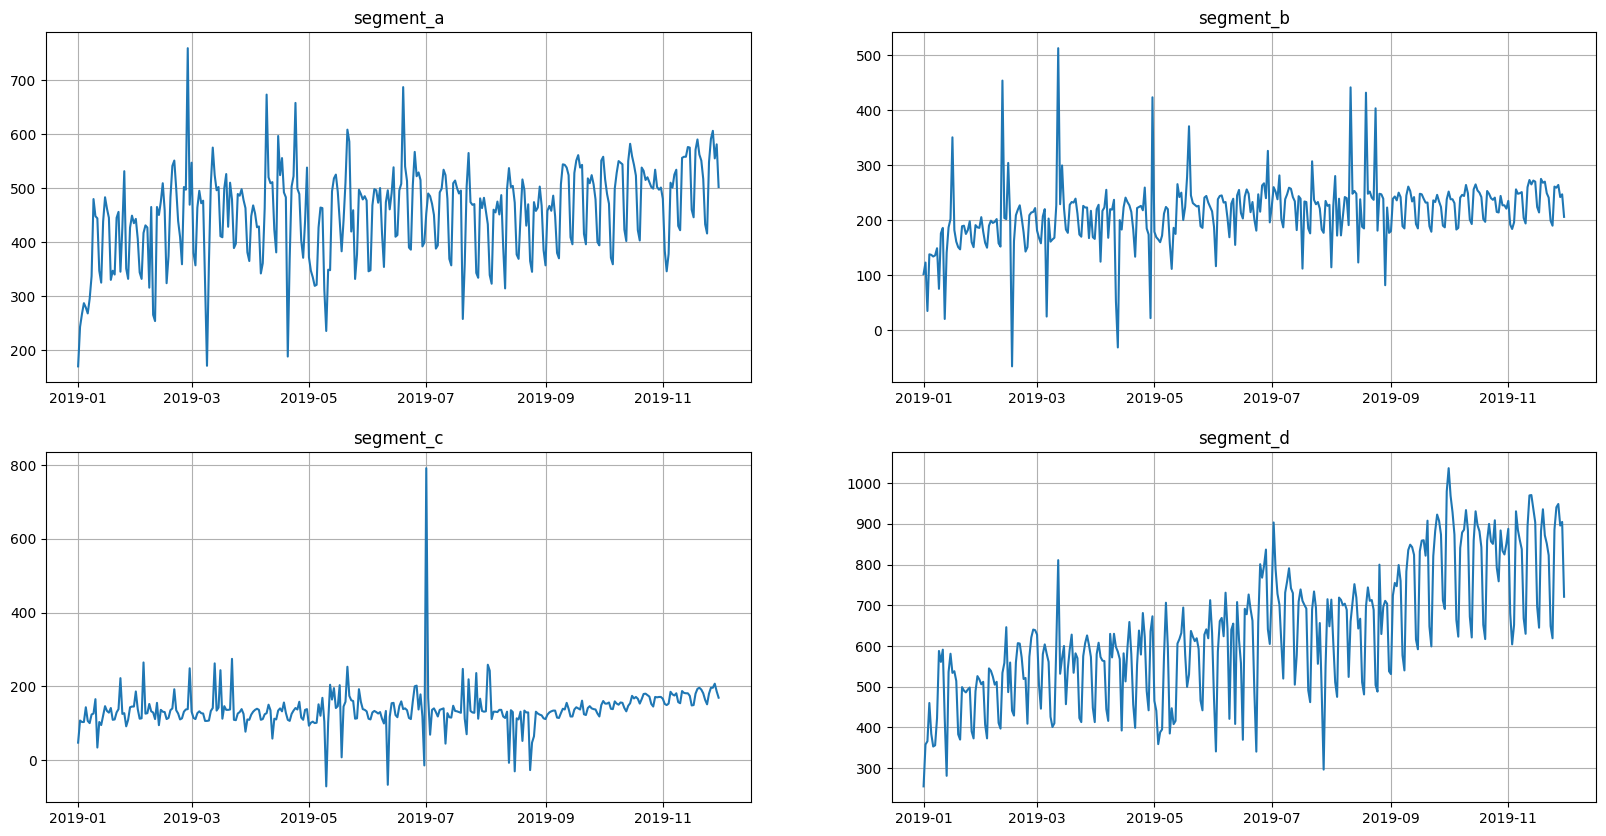

In [6]:
df = pd.read_csv("example_dataset_with_anomalies.csv")
ts = TSDataset(df=df, freq="D")
ts.plot()

Метрика стала чуть хуже -- в основной части задания вашей задачей будет это исправить

In [7]:
base_metric_with_anomalies = eval_pipeline(base_pipeline)
base_metric_with_anomalies

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily 

,0
SMAPE,10.253328


# Удаление аномалий с дефолтными гиперпараметрами(3 балла)

Попробуем несоклько методов поиска точечных аномалий, которые разбирались на лекции:
- `MedianOutliersTransform` -- в окне оцениваются параметры номарльного распределения, все что выходит за $median + alpha * std$ аномалии
- `DensityOutliersTransform` -- для каждой точки строится несколько окон в центром с ней $y + alpha * std$, если ни в одном окне нет хотябы $n\_neighbors$ соседей точка считается аномалией
- `PredictionIntervalOutliersTransform` -- все что выходит за доверительные интервалы пронозной модели аномалии

С помощью `*OutliersTransform` можно найти и заменить точечные аномалии на `NaN`. Для некоторых моделей получившиеся пропуски необходимо заполянть, однако Prophet умеет работать с пропущенными значениями -- поэтому сфокусируемся только на поиске аномалий

Постройте пайплайн с выделением аномалий через 3 данных метода с дефолтными гиперпараметрами и оцените качество прогнозов

(За каждый метод по баллу)

In [ ]:
from etna.transforms import MedianOutliersTransform, DensityOutliersTransform, PredictionIntervalOutliersTransform

In [10]:
from etna.models import ProphetModel

transforms = [
    MedianOutliersTransform(
        in_column="target",
        window_size=5,       # Окно для медианного сглаживания
        alpha=3.0            # Порог чувствительности
    ),
    DensityOutliersTransform(
        in_column="target",
        distance_coef=3.0    # Коэффициент расстояния
    ),
    PredictionIntervalOutliersTransform(
        in_column="target",
        model=ProphetModel, # Модель для расчета предиктивного интервала
        interval_width=0.95   # Доверительный интервал
    )
]

pipeline = Pipeline(
    model=ProphetModel(),
    transforms=transforms,
    horizon=HORIZON
)
eval_pipeline(pipeline)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

,0
SMAPE,8.877441


# Подберите гиперпараметры(6 баллов)
Теперь подберем отпимальные гиперпараметры наших методов(методы чувствительны к значениям гиперпараметров). На лекции качество методов оценивалось через классификационные метрики, однако в данном случае у нас нет на руках разметки. Предлагается подобрать гиперпараметры вторым методом -- по качеству решения задачи прогнозирования.

Для этого будем использовать механику перебора гиперпараметров на базе Optuna(подробнее тут https://github.com/etna-team/etna/blob/master/examples/205-automl.ipynb)

**В конце подведите итоги, какой метод оказался лучше?**

(За каждый метод по 2 балла)

In [11]:
from etna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution
from etna.auto import Tune

In [14]:
def get_best_params(pipeline, params_to_tune):
    tune = Tune(
        pipeline=pipeline,
        target_metric=SMAPE(), horizon=HORIZON, backtest_params=dict(n_folds=3),
        params_to_tune=params_to_tune
    )
    best_params = tune.fit(ts=ts, n_trials=3, catch=(Exception, ))
    best_metic = tune.summary()["SMAPE_mean"].min()
    return best_params, best_metic

In [12]:
tranforms = [
    MedianOutliersTransform(
        in_column="target",
        window_size=5,  # Будет изменяться при подборе
        alpha=3.0       # Будет изменяться при подборе
    ),
    DensityOutliersTransform(
        in_column="target",
        distance_coef=3.0  # Будет изменяться при подборе
    )
]

params_to_tune = {
    # Гиперпараметры для MedianOutliersTransform
    'transforms.0.window_size': IntDistribution(low=3, high=30, step=1),
    'transforms.0.alpha': FloatDistribution(low=1.0, high=5.0, step=0.1),

    # Гиперпараметры для DensityOutliersTransform
    'transforms.1.distance_coef': FloatDistribution(low=1.0, high=5.0, step=0.1),

    # Гиперпараметры для модели Prophet
    'model.seasonality_mode': CategoricalDistribution(choices=["additive", "multiplicative"]),
    'model.changepoint_prior_scale': FloatDistribution(low=0.001, high=0.5, step=0.01)
}

pipeline = Pipeline(
    model=ProphetModel(),
    transforms=tranforms,
    horizon=HORIZON
)

In [15]:
best_params, best_metric = get_best_params(pipeline, params_to_tune)

[I 2024-12-14 13:29:48,840] A new study created in RDB with name: no-name-67874602-7fa0-4b8c-af84-e7bb2885c1f6
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
INFO:prophet:Disabli

# Визуализируйте аномалии при оптимальных гиперпараметрах(1 балл)

Для того чтобы дополнительно убедиться что в итоге подобрались адекватные гиперпараметры, давайте визуализируем результаты

In [ ]:
from etna.analysis import plot_anomalies
from etna.analysis import get_anomalies_median, get_anomalies_density, get_anomalies_prediction_interval

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Визуализация аномалий на основе медианы:
Визуализация аномалий на основе плотности:
Визуализация аномалий на основе предиктивного интервала:


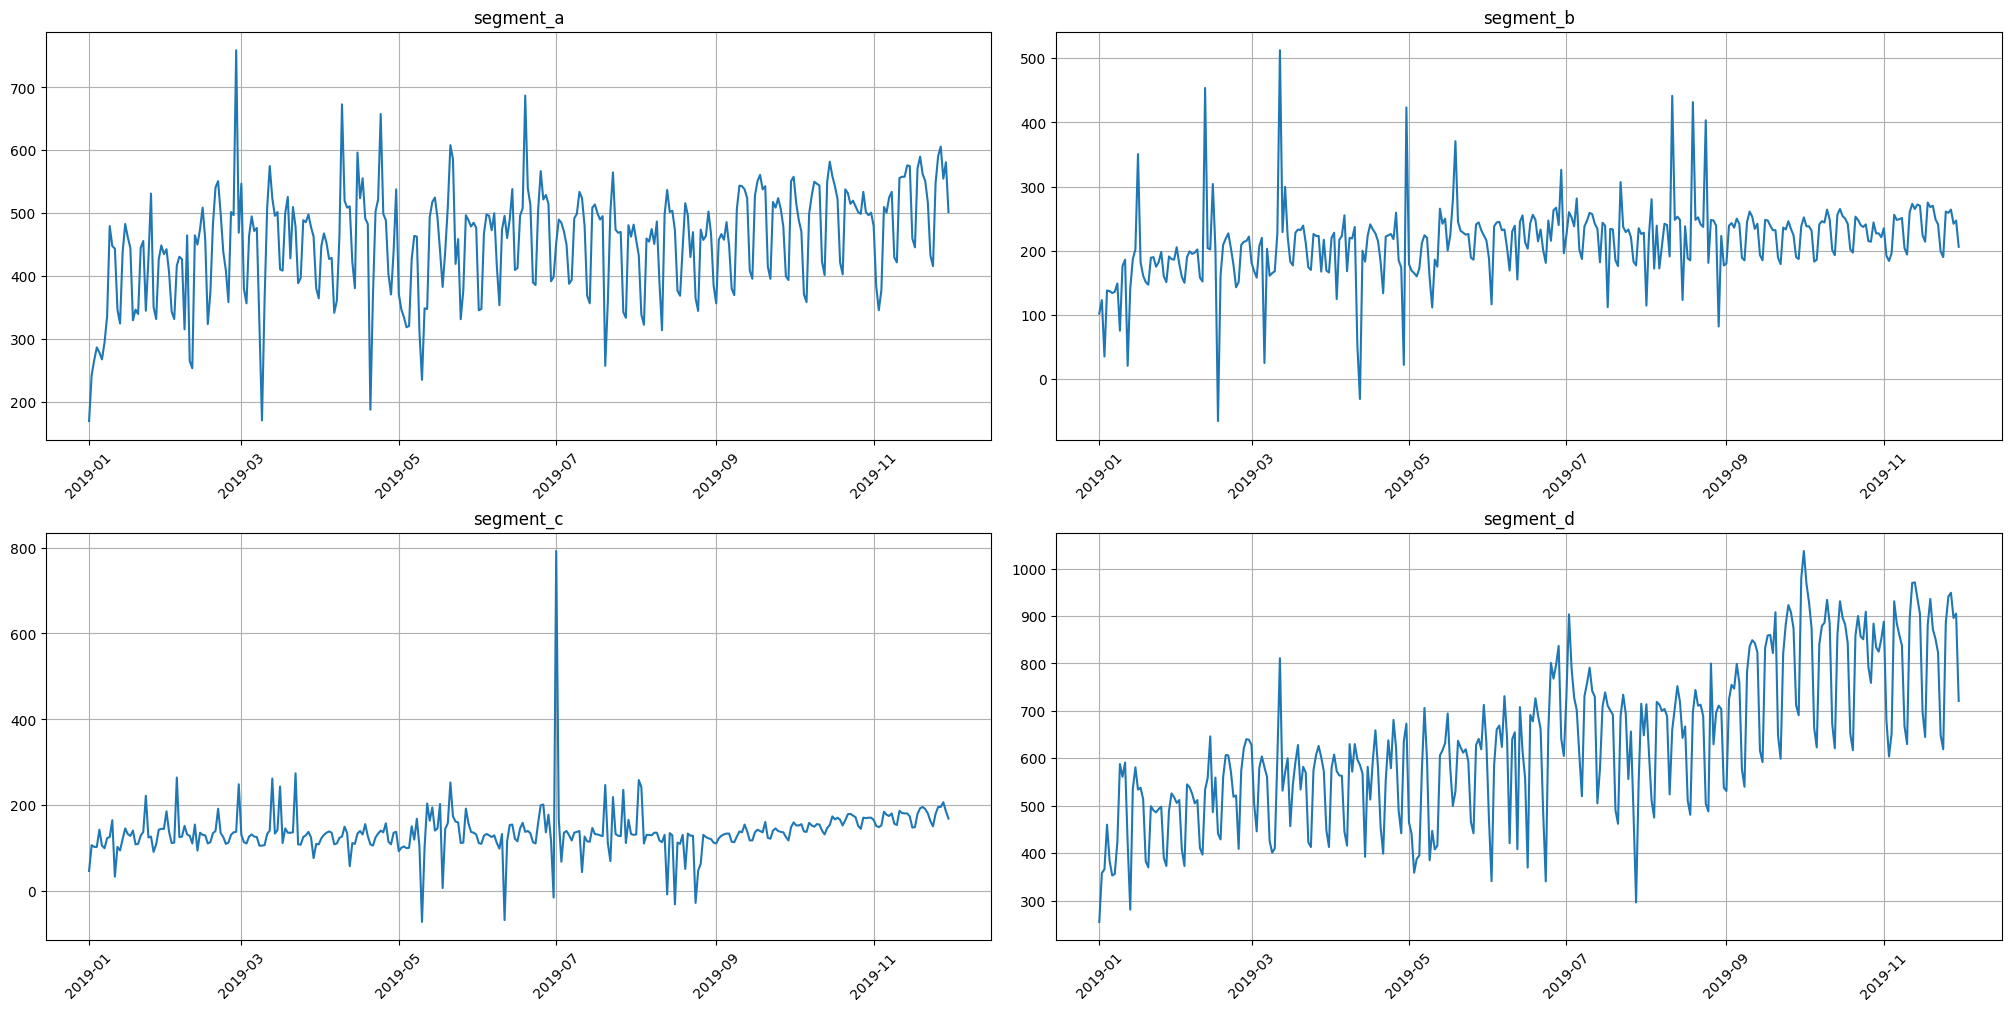

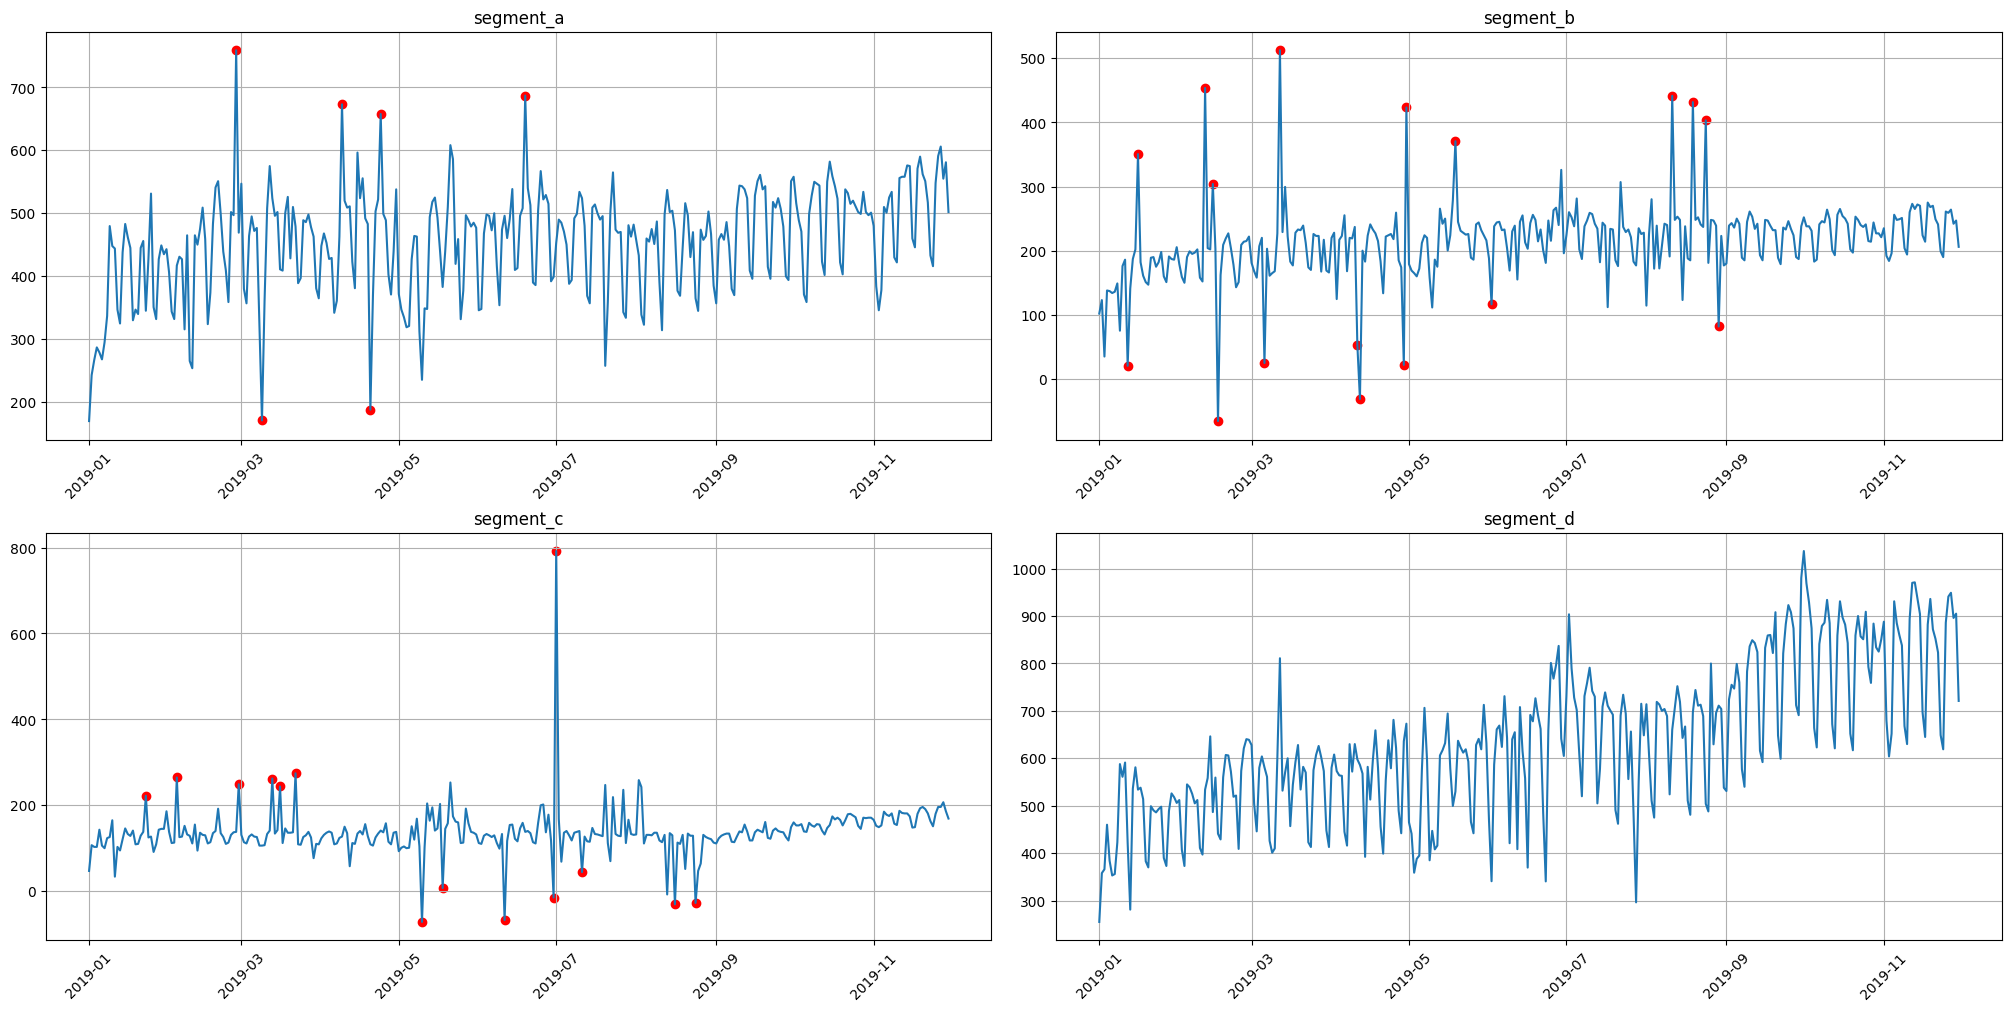

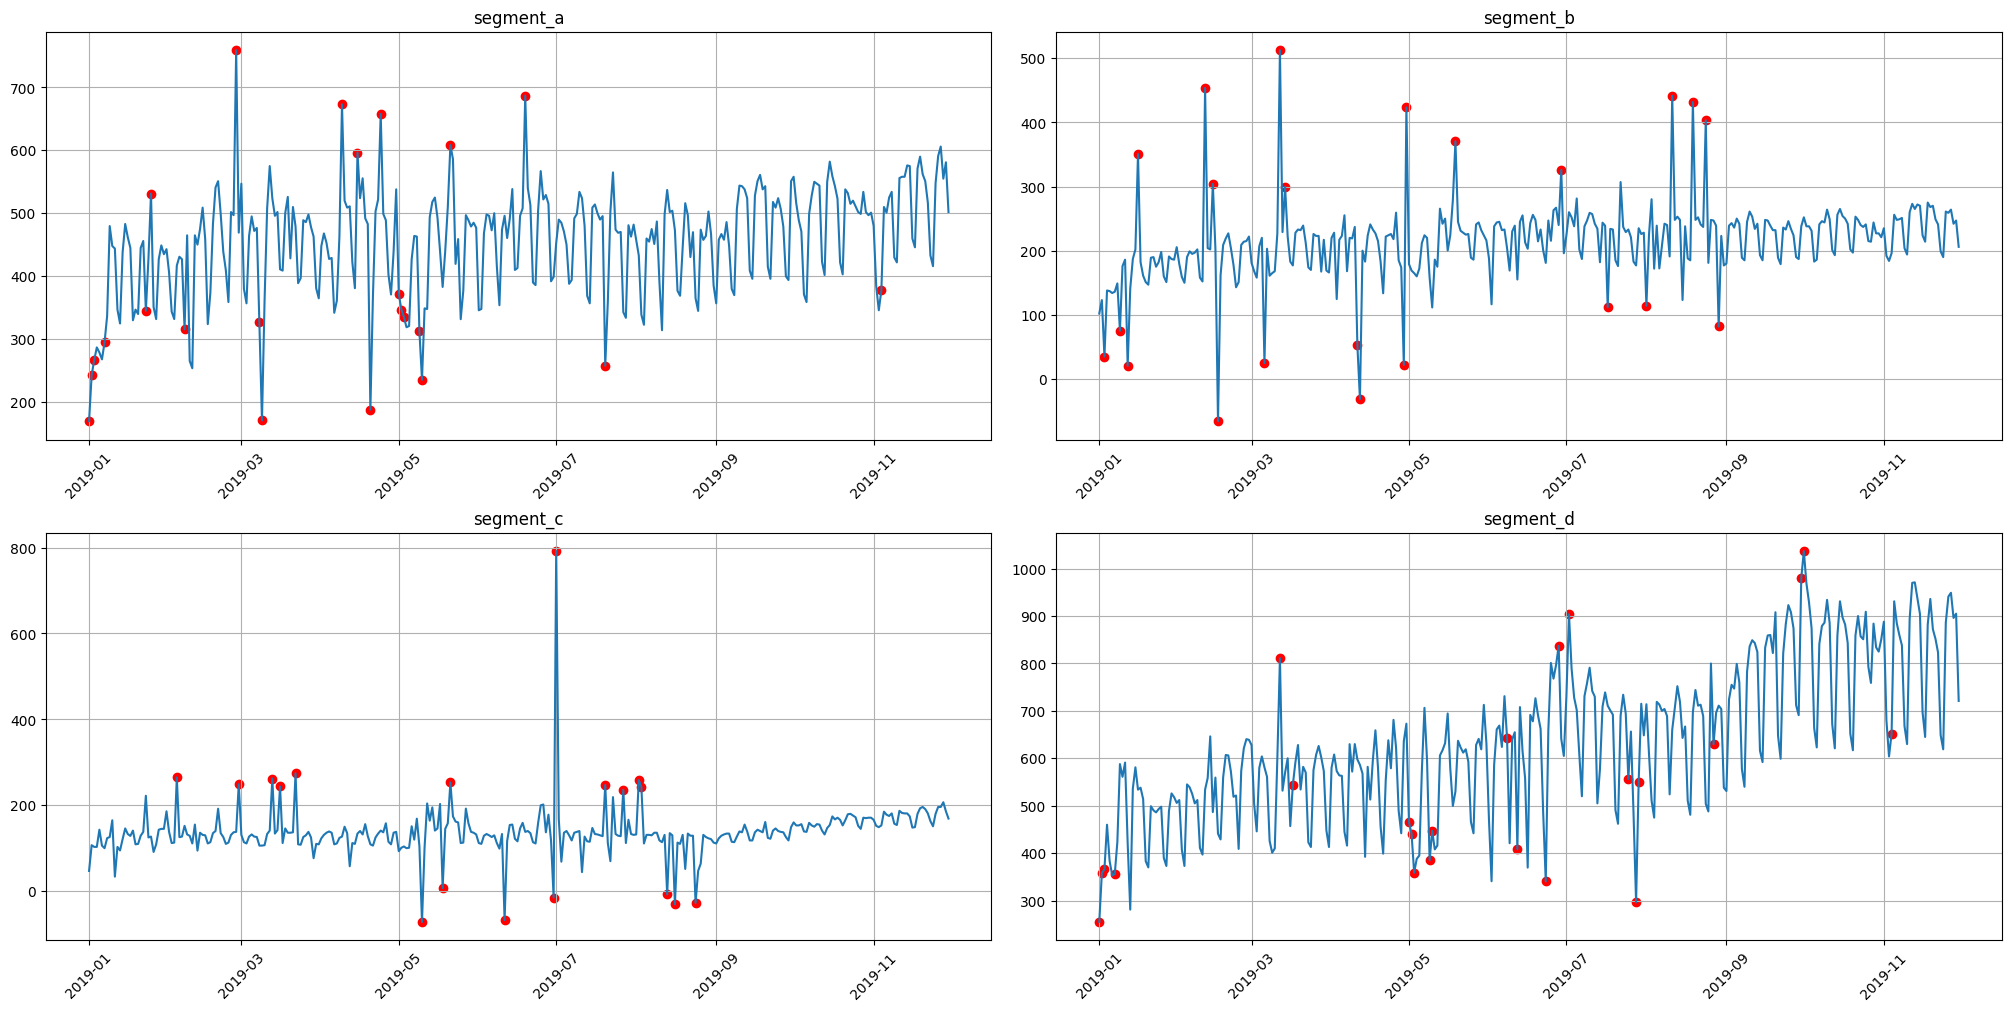

In [20]:
from etna.analysis import plot_anomalies
from etna.analysis import get_anomalies_median, get_anomalies_density, get_anomalies_prediction_interval
from etna.datasets import TSDataset

# 1. Выявление аномалий с использованием медианного метода
anomalies_median = get_anomalies_median(
    ts=ts,
    in_column="target",
    window_size=18,  # Размер окна для медианного сглаживания
    alpha=4.7       # Коэффициент чувствительности
)

# 2. Выявление аномалий на основе плотности
anomalies_density = get_anomalies_density(
    ts=ts,
    in_column="target",
    distance_coef=1.2  # Коэффициент для поиска аномалий
)

# 3. Выявление аномалий на основе предиктивного интервала
anomalies_prediction_interval = get_anomalies_prediction_interval(
    ts=ts,
    in_column="target",
    model=ProphetModel,  # Модель для предсказания
    interval_width=0.95    # Доверительный интервал
)

# Визуализация аномалий
print("Визуализация аномалий на основе медианы:")
plot_anomalies(ts, anomalies_median)

print("Визуализация аномалий на основе плотности:")
plot_anomalies(ts, anomalies_density)

print("Визуализация аномалий на основе предиктивного интервала:")
plot_anomalies(ts, anomalies_prediction_interval)
